In [85]:
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns
sns.set()

In [91]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [92]:
y = train["Survived"]
X_train = train.drop(["Survived"], axis=1)

X_train[:5]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


177


/home/fd99od/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


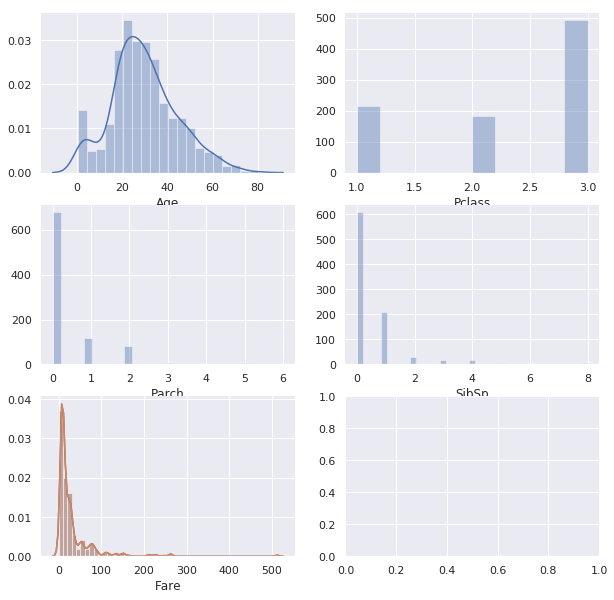

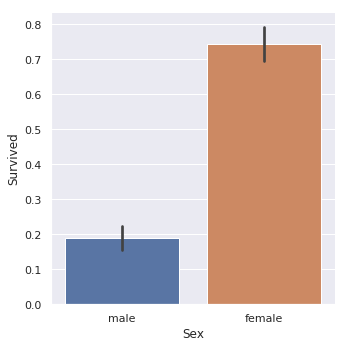

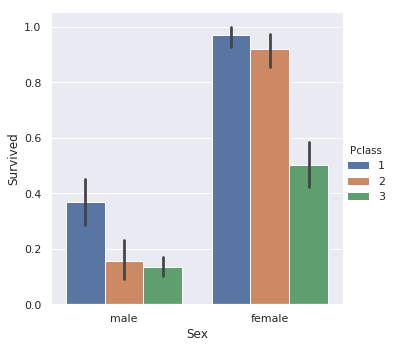

In [78]:
print(train["Age"].isna().count() - train["Age"].count())

# Set up the matplotlib figure
f, axes = plt.subplots(3, 2, figsize=(10, 10))
sns.despine(left=True)

sns.distplot(train["Age"].dropna(), ax=axes[0,0])
sns.distplot(train["Pclass"], ax=axes[0,1], kde=False)
sns.distplot(train["Parch"], ax=axes[1,0], kde=False)
sns.distplot(train["SibSp"], ax=axes[1,1], kde=False)
sns.distplot(train["Fare"], ax=axes[2,0])
sns.distplot(train["Fare"], ax=axes[2,0])

sns.catplot(x="Sex", y="Survived", kind="bar", data=train)
sns.catplot(x="Sex", y="Survived", kind="bar", data=train, hue="Pclass")

In [93]:
print("Pclass: ", X_train["Pclass"].hasnans)
print("Sex: ", X_train["Sex"].hasnans)
print("SibSp: ", X_train["SibSp"].hasnans)
print("Parch: ", X_train["Parch"].hasnans)
print("Embarked: ", X_train["Embarked"].hasnans)
print("Cabin: ", X_train["Cabin"].hasnans)
print("Fare: ", X_train["Fare"].hasnans)

# Fill Na values
X_train["Cabin"] = X_train["Cabin"].fillna("UNKNOWN").apply(lambda x: x[0])
print(X_train["Cabin"].unique())

print(X_train["Embarked"].hasnans)
print(X_train["Cabin"].hasnans)

X_train.head()
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.20, random_state=42)

Pclass:  False
Sex:  False
SibSp:  False
Parch:  False
Embarked:  True
Cabin:  True
Fare:  False
['U' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']
False
False


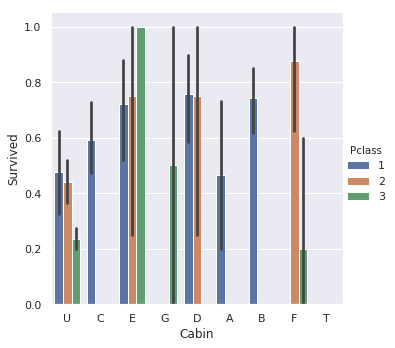

In [102]:
data = X_train.assign(Survived=y_train)
sns.catplot(x="Cabin", y="Survived", kind="bar", data=data, hue="Pclass")

In [125]:
# Impute and scale with median
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Imputer with constant fill_value and onehotencode
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value="UNKNOWN")),
    ('onehot', OneHotEncoder())])

def take_first_char(df):
    df["Cabin"] = df["Cabin"].apply(lambda x: x[0])
    return df

# Imputer with constant fill_value, take leading character and onehotencode
onehot_replace_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value="UNKNOWN")),
    ('replacer', FunctionTransformer(take_first_char)),
    ('onehot', OneHotEncoder())])

ct = ColumnTransformer([
    ("onehotencode", OneHotEncoder(dtype='int'), ["Pclass", "Sex", "SibSp", "Parch"]),
    ("impute-and-onehot-embarked", onehot_transformer, ["Embarked"]),
    ("impute-and-scale-age", numeric_transformer, ["Age"]),
    ("scale-age,fare", StandardScaler(), ["Fare"])
])

ct.fit_transform(X_train)

# print("Nans after transform: ", np.isnan(matrix.data).any())

<712x25 sparse matrix of type '<class 'numpy.float64'>'
	with 4984 stored elements in Compressed Sparse Row format>

In [126]:
clf = Pipeline(
    steps = [('data-transformer', ct),
             ('randomforest', RandomForestClassifier(n_estimators=100))]
)

clf.fit(X_train, y_train)

clf.score(X_train, y_train)
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(clf.score(X_test, y_test))

[[90 15]
 [17 57]]
0.8212290502793296
